# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [7]:
from thick_ptycho.simulation.config import SimulationConfig, ProbeType, ProbeConfig
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEPetscFullPinTSolver
import os


import time
import numpy as np


from utils import plot_solution, create_random_circle_object, plot_probes, plot_data

### 2. Create Simulated Sample and Space

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [8]:
probe_config = ProbeConfig(
    type=ProbeType.AIRY_DISK,
    wave_length=6.35e-7,  # meters (0.635 μm). Visible light
    diameter=10e-6,  # [m]
    focus=-5e-6,  # focal length [m]
)
n_medium = 1.0  # Refractive index of surrounding medium

In [9]:
# Width Discretization (Pixels)
scan_points = 60
step_size_px = 40  # Resolution
pad_factor = 2.5  # Must be >= 1.0
# Overlap = N - (scan_points*step_size_px) = padding
# Overlap factor = (N - (scan_points*step_size_px)) / step_size_px
#                = (pad_factor*scan_points) - scan_points) = scan_points*(pad_factor - 1)
# N = int(pad_factor*scan_points*step_size_px)
solve_reduced_domain = True

# Thickness Discretization (Pixels)
points_per_wavelength = 12  # Points per Wavelength for Parallel Wave Equation Solver
# nz = 50  # Slices for Multi-Slice
# Then:
#  - dz = wavelength / points_per_wavelength
#  - nz = int((zlims[1] - zlims[0]) / dz)
# Override by setting nz directly


# --- Simulation spatial dimensions (in meters) ---
spatial_limits = Limits(
    x=(0.0, 150e-6),  # Sample width
    z=(0.0, 75e-6),  # Sample thickness
    units="meters",
)

In [10]:
# --- Create the SimulationConfig object ---
# Defines scan path, probe parameters, discretization,
# object domain.
# Solver parameters are defined in the solver classes.
sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=solve_reduced_domain,
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=n_medium,  # 1.0 for free space
    # Logging and results
    results_dir="./results",
    use_logging=True,
    empty_space_px=2000
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()
print("Padding/Overlap:", simulation_space.nx - simulation_space.min_nx)

2025-12-14 21:32:27,178 - INFO - === Scan Summary ===
2025-12-14 21:32:27,180 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-14 21:32:27,181 - INFO -   Sample space (z-range): 7.500e-05 m
2025-12-14 21:32:27,181 - INFO -   Sample Pixels:          6001 px
2025-12-14 21:32:27,182 - INFO -   Step size:              40 px
2025-12-14 21:32:27,183 - INFO -   Number of scan points:  60
2025-12-14 21:32:27,184 - INFO -   Steps in z:             1417
2025-12-14 21:32:27,184 - INFO -   Solve reduced domain:   3640 px
2025-12-14 21:32:27,185 - INFO -   Max Overlap Pixels:     3601 px
2025-12-14 21:32:27,186 - INFO -   Probe diameter:         1.000e-05 m
2025-12-14 21:32:27,187 - INFO -   Probe Pixels:           400 px
2025-12-14 21:32:27,188 - INFO -   Max Overlap:            9.000e-06 m
2025-12-14 21:32:27,189 - INFO -   Percentage Overlap:     90.00%



Padding/Overlap: 3601


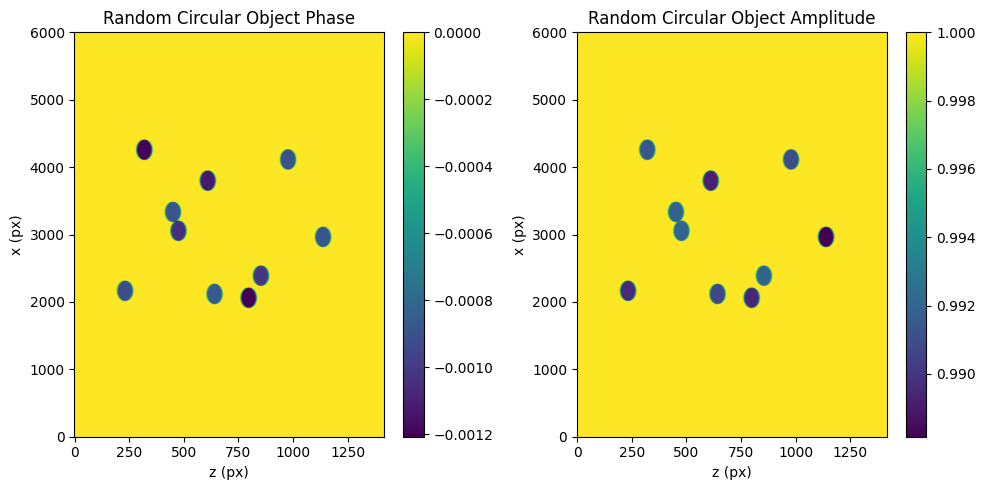

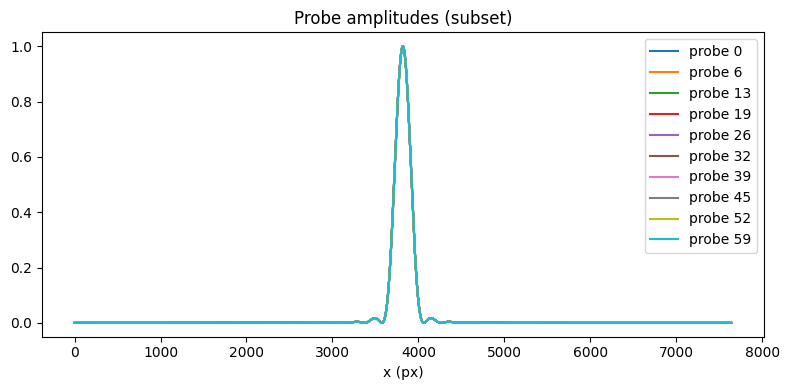

In [11]:
ptycho_object = create_ptycho_object(simulation_space)

ptycho_object = create_random_circle_object(simulation_space, ptycho_object)


# --- Create a set of Simulated Ptycho Probes (not dependent on number of slices/steps) ---
ptycho_probes = create_ptycho_probes(simulation_space)

plot_probes(simulation_space, ptycho_probes)

### 3. Generate Data with Fine nz Discretization

Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [12]:
# Solve Full Space Space, Iterative
# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe = PWEPetscFullPinTSolver(
    simulation_space,
    ptycho_probes,
    bc_type="impedance",
    alpha=1e-8,
    atol=1e-4,
    verbose=True,
)

# Iterative solution
u_fine = forward_model_pwe.solve(n=ptycho_object.refractive_index)
time_end = time.time()
print(
    f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n"
)
data_ew = forward_model_pwe.get_exit_waves(u_fine)
data = forward_model_pwe.get_farfield_intensities(
    exit_waves=data_ew, poisson_noise=False
)

Setting up PETSc system...
PETSc system setup time: 0.45 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 1.243e+01
Pre-factorizing PiT preconditioner blocks for mode 'forward'...


/home/dnz75396/thick_ptycho/thick_ptycho/forward_model/pwe/solvers/utils/_pint_utils.py:171: SparseEfficiencyWarning: splu converted its input to CSC format
  spla.splu((self.A_bar - (z * self.B_bar)).astype(self.dtype))


PiT preconditioner block factorization time: 9.10 seconds.

  Iter   1 | Residual: 4.036e-01
  Iter   2 | Residual: 6.885e-02
  Iter   3 | Residual: 6.753e-03
  Iter   4 | Residual: 4.703e-04
  Iter   5 | Residual: 2.603e-05
PETSc GMRES solve time: 34.16 s
Time: 34.16 s. Iters: 5. Reason: 3
[PWEPetscFullPinTSolver] solved probe 1/60 at angle _idx 0 in 35.53s
Setting up PETSc system...
PETSc system setup time: 0.49 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 2.069e-01
  Iter   1 | Residual: 3.321e-02
  Iter   2 | Residual: 5.121e-03
  Iter   3 | Residual: 5.366e-04
  Iter   4 | Residual: 3.624e-05
PETSc GMRES solve time: 19.09 s
Time: 19.09 s. Iters: 4. Reason: 3
[PWEPetscFullPinTSolver] solved probe 2/60 at angle _idx 0 in 20.33s
Setting up PETSc system...
PETSc system setup time: 0.43 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 2.159e-01
  Iter   1 | Residual: 3.522e-02
  Iter   2 | Residual: 5.905e-03
  Iter   3 | Residual: 6.053e-04
  Iter   4 | Resid

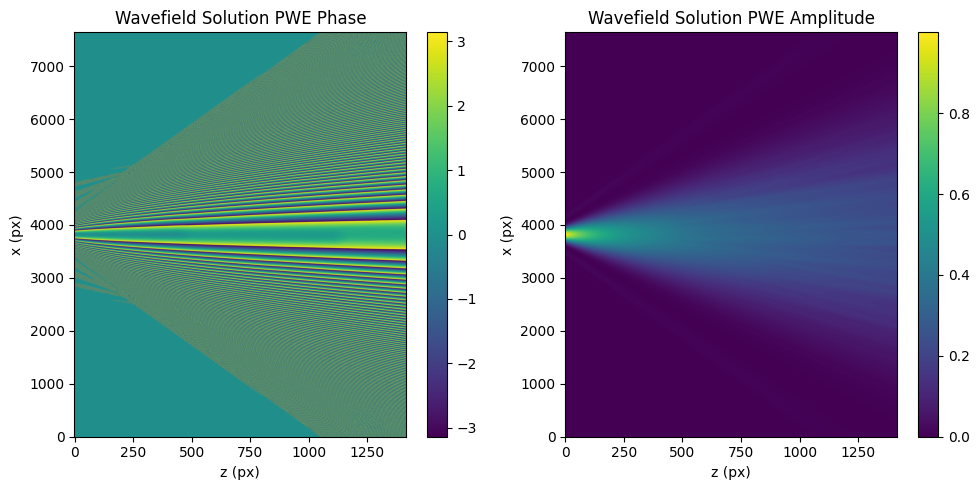

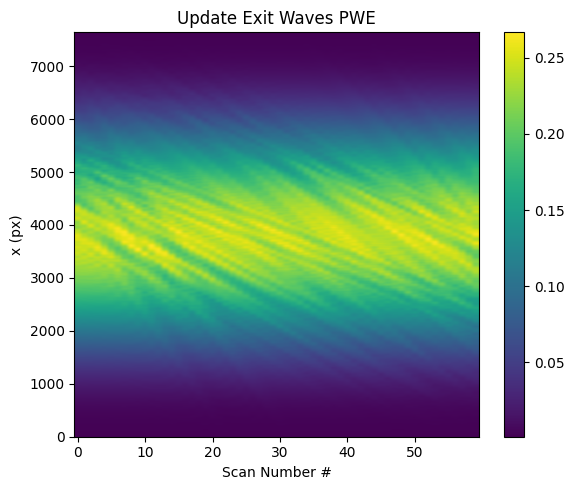

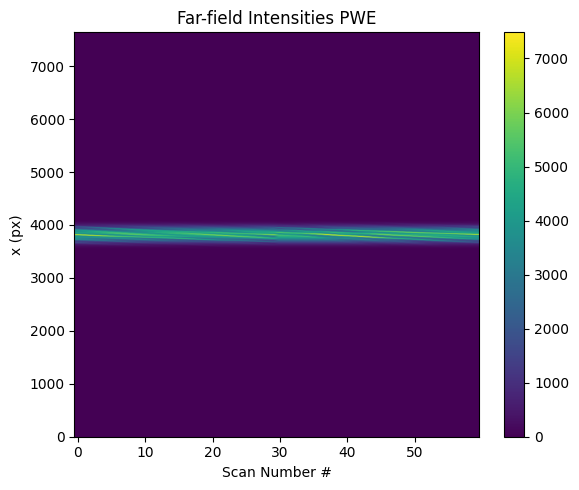

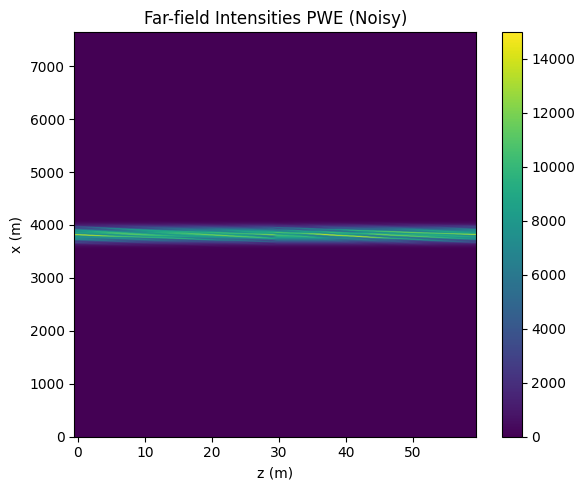

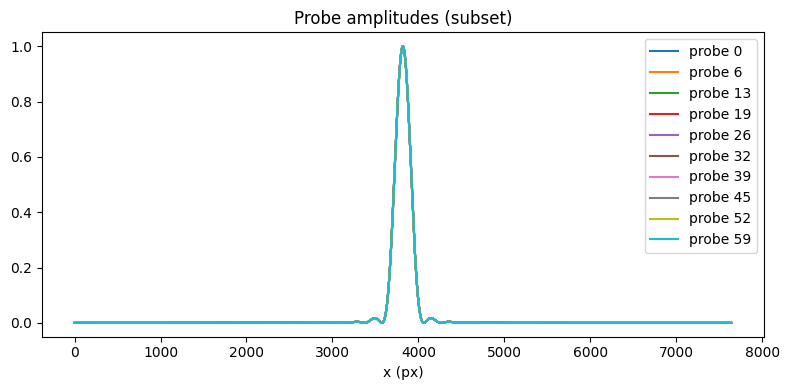

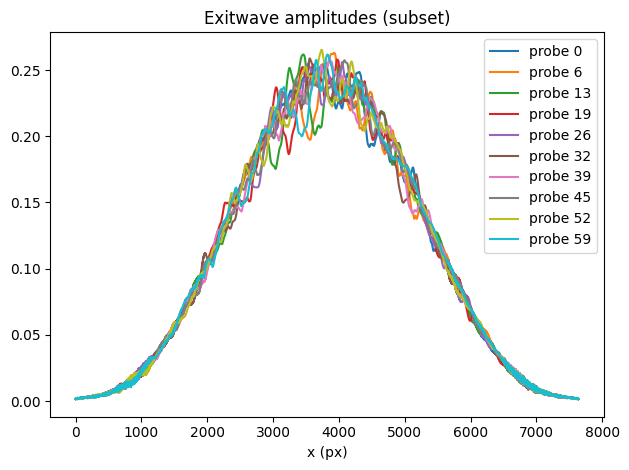

In [13]:
plot_solution(simulation_space, solution=u_fine)
plot_data(simulation_space, data=data, exitwaves=data_ew, probes=ptycho_probes)


In [14]:
# import pickle
from dataclasses import asdict

np.savez_compressed(
    os.path.join("./results", "padded_simulated_data_petsc.npz"),
    sim_config=asdict(sim_config),
    exit_waves=data_ew,
    ref_index=ptycho_object.refractive_index,
)